In [ ]:
!python -m pip install --upgrade pip
!pip install numpy pandas
!pip install torch torchaudio

In [ ]:
# Install the 'evaluate' library with the specified version (4.28.1) quietly (-q).
%pip install -q evaluate transformers==4.28.1

# Upgrade the 'datasets' library to the latest version quietly (-q).
%pip install -U -q datasets

# Install the 'torchaudio' library with the specified version (0.12.0+cu113) from the provided CUDA version repository.
%pip install -q torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# Add the 'ffmpeg4' repository to the package manager's sources list (-y for yes).
%add-apt-repository -y ppa:savoury1/ffmpeg4 

# Install the 'ffmpeg' package quietly (-qq).
%apt-get -qq install -y ffmpeg

# Install the 'mlflow' library quietly (-q).
%pip install -q mlflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1 requires torch==2.5.1, but you have torch 1.12.0+cu113 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%add-apt-repository` not found.


In [ ]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import gc  # Garbage collection module
import re  # Regular expressions for text processing
import numpy as np  # NumPy for numerical operations

# Suppress warnings
import warnings 
warnings.filterwarnings("ignore")

# Import tqdm for progress tracking
from tqdm import tqdm
# tqdm.pandas()

# Import Path from pathlib for working with file paths
from pathlib import Path

# Import oversampling and undersampling methods from imblearn
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# Import class_weight calculation function from scikit-learn
from sklearn.utils.class_weight import compute_class_weight

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import itertools for working with iterators
import itertools

# Import various metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import PyTorch for deep learning
import torch

# Import the Hugging Face Transformers library
import transformers

# Print the version of the transformers library
print(transformers.__version__)

# Import torchaudio for audio processing with PyTorch
import torchaudio

# Print the version of torchaudio
print(torchaudio.__version__)

# Import a custom module named 'evaluate' for evaluation functions
# import evaluate

# Import Audio for displaying audio clips in the notebook
from IPython.display import Audio

# Import various classes and modules from Hugging Face Transformers and Datasets
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes

## Load and filter data


In [1]:
import pandas as pd
file_path = '../data/train_audio/train_metadata.csv'  
df = pd.read_csv(file_path)
df.head()  

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [2]:
# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 10

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Define the minimum number of records per label required for the dataset
MIN_RECORDS_PER_LABEL = 26

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.1

# Ensure that the product of MIN_RECORDS_PER_LABEL and TEST_SIZE is greater than 2
# This ensures a sufficient number of samples for testing

In [3]:
filtered_df = df[
    (df['secondary_labels'].apply(lambda x: isinstance(x, str) and len(x) == 2)) &
    (df['type'].apply(lambda x: 'call' in x)) &
    (df['rating'].apply(lambda x: x >= 3.0))  
]

print(filtered_df.shape)

df_filtered = filtered_df[['primary_label', 'type', 'latitude', 'longitude','rating', 'filename']].copy()
df_filtered['filename'] = '../data/train_audio/train_audio/' + df_filtered['filename'].astype(str)

df_filtered.head()

# Calculate label counts
label_counts = df_filtered['primary_label'].value_counts()

# Identify undersampled labels
undersampled_labels = label_counts[label_counts < MIN_RECORDS_PER_LABEL].index

# Remove rows with undersampled labels
df_filtered = df_filtered[~df_filtered['primary_label'].isin(undersampled_labels)]

# Print the shape of the resulting DataFrame
print(df_filtered.shape)

df_filtered.head()

(10333, 12)
(9336, 6)


,primary_label,type,latitude,longitude,rating,filename
0,asbfly,['call'],39.2297,118.1987,5.0,../data/train_audio/train_audio/asbfly/XC13489...
3,asbfly,['call'],21.1697,70.6005,4.0,../data/train_audio/train_audio/asbfly/XC20773...
4,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...
5,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...
7,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,../data/train_audio/train_audio/asbfly/XC26768...


In [4]:
# Retrieve unique values in the 'label' column of the DataFrame 'df'
unique_labels = df_filtered['primary_label'].unique()
unique_labels

array(['asbfly', 'ashdro1', 'ashpri1', 'asikoe2', 'barswa', 'bcnher',
       'bkskit1', 'bkwsti', 'bladro1', 'blakit1', 'blhori1', 'blnmon1',
       'blrwar1', 'brnhao1', 'brnshr', 'brodro1', 'brwowl1', 'categr',
       'cohcuc1', 'comgre', 'comior1', 'comkin1', 'commoo3', 'commyn',
       'compea', 'comros', 'comsan', 'comtai1', 'copbar1', 'crseag1',
       'eaywag1', 'eucdov', 'eurcoo', 'gargan', 'gloibi', 'graher1',
       'grbeat1', 'grecou1', 'greegr', 'grefla1', 'grejun2', 'grewar3',
       'grnsan', 'grnwar1', 'grtdro1', 'gryfra', 'grywag', 'gybpri1',
       'gyhcaf1', 'hoopoe', 'houcro1', 'houspa', 'indpit1', 'insbab1',
       'insowl1', 'junowl1', 'kenplo1', 'labcro1', 'lblwar1', 'lirplo',
       'litegr', 'litgre1', 'litspi1', 'litswi1', 'marsan', 'nutman',
       'oripip1', 'piekin1', 'plapri1', 'purher1', 'pursun3', 'pursun4',
       'putbab1', 'rerswa1', 'revbul', 'rewbul', 'rewlap1', 'rocpig',
       'rorpar', 'ruftre2', 'shikra1', 'stbkin1', 'tibfly3', 'wemhar1',
       

In [5]:
bird_counts = df_filtered['primary_label'].value_counts()
print(bird_counts)

primary_label
comkin1    308
eurcoo     288
graher1    277
bkwsti     277
commoo3    270
          ... 
junowl1     30
asbfly      28
gryfra      28
grejun2     27
insowl1     26
Name: count, Length: 90, dtype: int64


In [6]:
# Get the top 15 bird categories based on counts
top_15_labels = df_filtered['primary_label'].value_counts().head(15).index

# Filter the DataFrame to keep only the rows with these top 15 labels
filtered_df_top_15 = df_filtered[df_filtered['primary_label'].isin(top_15_labels)]

# Display the filtered DataFrame
print(filtered_df_top_15)


      primary_label                                       type  latitude  \
709          barswa                            ['flight call']   46.1540   
711          barswa                           ['call', 'song']   30.0801   
712          barswa                             ['alarm call']   39.5224   
713          barswa                             ['alarm call']   51.0383   
716          barswa                             ['alarm call']   50.7380   
...             ...                                        ...       ...   
23726        woosan               ['call', 'single-note call']   51.4812   
23727        woosan               ['call', 'single-note call']   51.4812   
23728        woosan               ['call', 'single-note call']   51.4812   
23729        woosan                  ['nocturnal flight call']   43.0353   
23730        woosan  ['adult', 'flight call', 'sex uncertain']   -2.9858   

       longitude  rating                                           filename  
709     -

In [10]:
bird_counts = filtered_df_top_15['primary_label'].value_counts()
print(bird_counts)

primary_label
comkin1    308
eurcoo     288
bkwsti     277
graher1    277
commoo3    270
bcnher     268
rorpar     261
comgre     248
grnsan     248
litegr     248
comsan     246
eaywag1    245
barswa     228
woosan     225
lirplo     223
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Function to save DataFrame to CSV
def save_audio_dataframe(df, filename):
    """
    Save a DataFrame with an 'audio' column (list of floats) to a CSV file.

    Args:
        df (pd.DataFrame): The DataFrame containing 'audio' and 'label'.
        filename (str): Name of the file to save as CSV.
    """
    # Convert the 'audio' column (list of floats) into a string representation
    df['audio'] = df['audio'].apply(lambda x: ','.join(map(str, x)))
    
    # Save the DataFrame as a CSV file
    df.to_csv(filename, index=False)
    print(f"DataFrame saved to {filename}")


In [ ]:
import numpy as np
import pandas as pd
# Function to read the CSV and convert 'audio' back to list
def read_audio_dataframe(filename):
    """
    Read a CSV file and convert the 'audio' column back to a list of floats.

    Args:
        filename (str): The name of the CSV file.
    
    Returns:
        pd.DataFrame: The DataFrame with 'audio' restored as lists.
    """
    df = pd.read_csv(filename)
    # Convert the 'audio' column back into lists of floats
    df['audio'] = df['audio'].apply(lambda x: np.array(list(map(float, x.split(','))), dtype=np.float32))
    return df

# Example: Read the CSV and restore 'audio'
# restored_df = read_audio_dataframe('audio_data.csv')
# print(len(restored_df))
# # df = restored_df


In [ ]:
import csv 

def write_output_csv(output_file,  fft_features, label):
    with open(output_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        row = [label] + fft_features.tolist() 
        writer.writerow(row)

## Split each audio in 10sec chunks 

In [6]:
df_filtered = df_filtered[:4500]
print(len(df_filtered))

4500


In [4]:
from tqdm import tqdm
import torchaudio

def split_audio(file):
    try:
        audio, rate = torchaudio.load(str(file))
        num_segments = (len(audio[0]) // MAX_LENGTH) 
        segmented_audio = []

        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = min((i + 1) * MAX_LENGTH, len(audio[0]))
            segment = audio[0][start:end]

            transform = torchaudio.transforms.Resample(rate, RATE_HZ)
            segment = transform(segment).squeeze(0).numpy().reshape(-1)

            segmented_audio.append(segment)
        
        df_segments = pd.DataFrame({'audio': segmented_audio})
        return df_segments

    except Exception as e:
        print(f"Error processing file: {e}")
        return None

df_list = []
for input_file, input_label in tqdm(zip(df_filtered['filename'].values, df_filtered['primary_label'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)
        
df = pd.concat(df_list, axis=0)
print(len(df))
# save_audio_dataframe(df, 'audio_data.csv')
df.head(5)

NameError: name 'df_filtered' is not defined

In [9]:
df.to_pickle('../data/seg_0000.csv')

In [ ]:
import numpy as np

df[['label']].to_csv("../data/conda/seg_4500.csv", index=False)

chunk_size = 5000
total_rows = len(df)

# Iterate over the dataframe in chunks
for i in range(0, total_rows, chunk_size):
    chunk = df.iloc[i:min(i + chunk_size, total_rows)]
    
    # Save the chunk as a .npy file
    np.save(f"./data/conda/audio_chunk_{(i // chunk_size)}.npy", np.array(chunk['audio'].tolist(), dtype=object))

print("All chunks saved successfully!")


In [ ]:
import gc

print("I am here")
del df_list
gc.collect()

I am here


1426

## Load data from saved files


In [2]:
import numpy as np
import pandas as pd

# Load the label files
labels1 = pd.read_csv("../data/audio_labels_segments_4500.csv")
labels2 = pd.read_csv("../data/audio_labels_segments_4500_.csv")

# Combine the label dataframes (assuming they have the same structure and can be concatenated)
labels_combined = pd.concat([labels1, labels2], ignore_index=True)

print(labels_combined.shape)
labels_combined.to_csv("../data/audio_labels_total.csv", index=False)
labels_combined.head()

(60132, 1)


,label
0,asbfly
1,asbfly
2,asbfly
3,asbfly
4,asbfly


In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import glob

print(np.__version__)

# Initialize an empty list to hold the audio data
audio_data = []

# Dynamically identify audio chunks
audio_chunk_files = sorted(glob.glob("../data/audio_chunk_*.npy"))
print(audio_chunk_files)
total_chunks = len(audio_chunk_files)
print(f"Found {total_chunks} audio chunks.")

# Define labels_combined (assuming it's a DataFrame from a CSV)
labels_combined = pd.read_csv("../data/audio_labels_total.csv", index_col=0)  

# Use tqdm to show progress
for i, file in enumerate(tqdm(audio_chunk_files, desc="Loading audio chunks")):
    try:
        chunk = np.load(file, allow_pickle=True)
        audio_data.append(chunk)
    except Exception as e:
        print(f"Error loading chunk {i}: {e}")

# Combine all chunks into one array
audio_data_combined = np.concatenate(audio_data, axis=0)

# Ensure the lengths match
assert len(audio_data_combined) == len(labels_combined), "The length of audio and labels do not match!"

# Create a DataFrame from the combined audio and labels
df_combined = pd.DataFrame({
    'audio': list(audio_data_combined),
    'label': labels_combined['label']
})

print("Data combined and saved successfully!")
print(df_combined.head())

1.26.4
['../data/audio_chunk_0.npy', '../data/audio_chunk_1.npy', '../data/audio_chunk_10.npy', '../data/audio_chunk_11.npy', '../data/audio_chunk_12.npy', '../data/audio_chunk_2.npy', '../data/audio_chunk_3.npy', '../data/audio_chunk_4.npy', '../data/audio_chunk_5.npy', '../data/audio_chunk_6.npy', '../data/audio_chunk_7.npy', '../data/audio_chunk_8.npy', '../data/audio_chunk_9.npy']
Found 13 audio chunks.
1


: 

: 

In [1]:
import pandas as pd
#first 4500 files splits
df = pd.read_pickle('../data/seg_0000.csv')

print(len(df))

29632


In [2]:
df.head()

import pandas as pd
from sklearn.utils import resample

# Assuming `df` is your dataset
print(df['label'].value_counts())  # Check class distribution

# Find the minimum number of samples in any class
min_samples = df['label'].value_counts().min()

# Group the dataset by class and undersample
balanced_df = pd.concat(
    [
        resample(group, replace=False, n_samples=min_samples, random_state=42)
        for _, group in df.groupby('label')
    ]
)

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['label'].value_counts())  # Check new class distribution


label
commyn     2402
graher1    2130
bkwsti     2077
bcnher     1611
barswa     1581
comkin1    1569
bkskit1    1416
eurcoo     1343
eaywag1    1253
comsan     1184
comgre     1172
commoo3    1021
blakit1    1002
categr      873
comros      866
asikoe2     650
eucdov      647
cohcuc1     514
crseag1     504
comior1     492
comtai1     476
blrwar1     431
bladro1     427
blhori1     401
brnhao1     361
brnshr      356
brodro1     348
blnmon1     325
ashdro1     297
brwowl1     287
grecou1     268
gargan      225
asbfly      225
copbar1     224
grbeat1     199
ashpri1     169
gloibi      167
greegr       73
compea       66
Name: count, dtype: int64
label
categr     66
comior1    66
gloibi     66
comsan     66
comtai1    66
ashpri1    66
copbar1    66
barswa     66
bcnher     66
brodro1    66
asbfly     66
bkskit1    66
eaywag1    66
commyn     66
bladro1    66
graher1    66
commoo3    66
crseag1    66
grecou1    66
ashdro1    66
compea     66
eurcoo     66
bkwsti     66
comros     66
bl

In [3]:
import pandas as pd
# 4500 to last
df = pd.read_pickle('../data/seg_4500.csv')


In [6]:
final_df = pd.concat([balanced_df, df], axis=0, ignore_index=True)

class_counts = final_df['label'].value_counts()
undersampled_samples = []
min_class_count = class_counts.min()

for label in final_df['label'].unique():
    # Separate samples for the current class
    class_samples = final_df[final_df['label'] == label]
    
    # Resample the majority class to match the min class count
    class_samples_undersampled = resample(class_samples, 
                                          replace=False,  # Without replacement
                                          n_samples=min_class_count,  # To match the min class count
                                          random_state=42)  # For reproducibility
    
    # Append the resampled samples to the list
    undersampled_samples.append(class_samples_undersampled)

# Concatenate all the undersampled class samples back into a single DataFrame
undersampled_df_final = pd.concat(undersampled_samples, axis=0)

# Shuffle the final undersampled dataframe
undersampled_df_final = undersampled_df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the shape of the final undersampled dataset
print(f"Undersampled DataFrame shape: {undersampled_df_final.shape}")


Undersampled DataFrame shape: (5940, 2)


In [7]:
undersampled_df_final.head()

,audio,label
0,"[-0.0025004786, -0.024634501, -0.035502415, -0...",whtkin2
1,"[0.03884741, 0.051573075, 0.03267537, 0.056989...",pursun4
2,"[-1.4708853e-05, -9.2778737e-07, 1.7867682e-06...",blhori1
3,"[0.0018872456, 0.0025542674, 0.0020124586, 0.0...",pursun4
4,"[-0.041582003, -0.0032551906, 0.059886623, 0.0...",bkskit1


In [10]:
bird_counts = undersampled_df_final['label'].value_counts()
print(bird_counts)


df = undersampled_df_final

label
whtkin2    66
grefla1    66
commoo3    66
asbfly     66
junowl1    66
           ..
grewar3    66
blrwar1    66
cohcuc1    66
bkwsti     66
crseag1    66
Name: count, Length: 90, dtype: int64


In [11]:
import gc
gc.collect()

0

## get only first 10sec chunk

In [9]:
from tqdm import tqdm
import torchaudio
import numpy as np
import torch
import gc
import noisereduce as nr
import pandas as pd

tqdm.pandas()  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


def denoise_audio(audio):
    # Assuming the audio is in numpy format and sample rate is known
    if audio.ndim == 2:
        audio = audio[0]
    audio_denoised = nr.reduce_noise(y=audio, sr=RATE_HZ)
    return audio_denoised

def get_transform_audio(file):
    try:
        audio, rate = torchaudio.load(str(file))
        audio = audio.to(DEVICE)
        
        transform = torchaudio.transforms.Resample(rate, RATE_HZ).to(DEVICE)
        audio = transform(audio)
        
        # Move to CPU for denoising
        audio_np = audio.cpu().numpy()
        audio_denoised = denoise_audio(audio_np)
        
        # Convert back to tensor and move to DEVICE
        audio = torch.from_numpy(audio_denoised).to(DEVICE)
        
        if audio.shape[0] > MAX_LENGTH:
            audio = audio[:MAX_LENGTH]
        else:
            padding = MAX_LENGTH - audio.shape[0]
            audio = torch.cat((audio, torch.zeros(padding, device=DEVICE)))
        
        audio = audio.cpu().numpy()
        
        del transform
        gc.collect()
        torch.cuda.empty_cache()
        
        return audio
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None

# Apply the function with GPU support to the DataFrame
df_filtered['audio'] = df_filtered['filename'].progress_apply(get_transform_audio)


cuda


100%|██████████| 9336/9336 [45:19<00:00,  3.43it/s]   


In [10]:
df_filtered.head()

,primary_label,type,latitude,longitude,rating,filename,audio
0,asbfly,['call'],39.2297,118.1987,5.0,../data/train_audio/train_audio/asbfly/XC13489...,"[5.3234883e-10, 3.9613293e-10, 1.5075596e-10, ..."
3,asbfly,['call'],21.1697,70.6005,4.0,../data/train_audio/train_audio/asbfly/XC20773...,"[-2.1100199e-08, 2.9910524e-07, -5.312917e-08,..."
4,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...,"[3.5228157e-05, 3.2542852e-05, 3.0595027e-05, ..."
5,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...,"[2.2625075e-06, 6.5277272e-06, 8.538891e-06, 1..."
7,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,../data/train_audio/train_audio/asbfly/XC26768...,"[4.3382702e-08, 7.115386e-08, -3.1326832e-07, ..."


In [11]:
# Create a new DataFrame with 'audio' and 'primary_label', renaming 'primary_label' to 'label'
new_df = df_filtered[['audio', 'primary_label']].rename(columns={'primary_label': 'label'})

import gc

del df_filtered
gc.collect()
# Display the first few rows of the new DataFrame to confirm
print(new_df.shape)
new_df.head()

(9336, 2)


,audio,label
0,"[5.3234883e-10, 3.9613293e-10, 1.5075596e-10, ...",asbfly
3,"[-2.1100199e-08, 2.9910524e-07, -5.312917e-08,...",asbfly
4,"[3.5228157e-05, 3.2542852e-05, 3.0595027e-05, ...",asbfly
5,"[2.2625075e-06, 6.5277272e-06, 8.538891e-06, 1...",asbfly
7,"[4.3382702e-08, 7.115386e-08, -3.1326832e-07, ...",asbfly


In [12]:
new_df.to_pickle('../data/10_secs_audio_denoise_9500.csv')
df = new_df

import gc
del new_df
gc.collect()

0

In [58]:
from IPython.display import Audio

def play_audio(audio, sample_rate):
    return Audio(audio, rate=sample_rate)

# Play the original and denoised audio
play_audio(df.iloc[1]['audio'], RATE_HZ)  # Denoised audio


In [1]:
import pandas as pd

df = pd.read_pickle('../data/10_secs_audio_denoise_9500.csv')

print(len(df))

9336


In [56]:
import pandas as pd

df_org = pd.read_pickle('../data/10_secs_audio_9500.csv')

print(len(df_org))

9336


## After loading 


In [63]:
import pandas as pd
from sklearn.utils import resample

# Assuming `df` is your dataset
print(df['label'].value_counts())  # Check class distribution

# Find the minimum number of samples in any class
min_samples = df['label'].value_counts().min()

# Group the dataset by class and undersample
balanced_df = pd.concat(
    [
        resample(group, replace=False, n_samples=min_samples, random_state=42)
        for _, group in df.groupby('label')
    ]
)

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['label'].value_counts())  # Check new class distribution


label
comkin1    308
eurcoo     288
graher1    277
bkwsti     277
commoo3    270
          ... 
junowl1     30
asbfly      28
gryfra      28
grejun2     27
insowl1     26
Name: count, Length: 90, dtype: int64
label
bladro1    26
bkskit1    26
kenplo1    26
brodro1    26
eaywag1    26
           ..
gryfra     26
plapri1    26
comior1    26
bcnher     26
hoopoe     26
Name: count, Length: 90, dtype: int64


In [3]:
print(len(balanced_df))

df= balanced_df

NameError: name 'balanced_df' is not defined

In [12]:
print(df.memory_usage(deep=True).sum() / 1e6, "MB")  

1.091108 MB


In [13]:
df.head()

,audio,label
0,"[-0.0025004786, -0.024634501, -0.035502415, -0...",whtkin2
1,"[0.03884741, 0.051573075, 0.03267537, 0.056989...",pursun4
2,"[-1.4708853e-05, -9.2778737e-07, 1.7867682e-06...",blhori1
3,"[0.0018872456, 0.0025542674, 0.0020124586, 0.0...",pursun4
4,"[-0.041582003, -0.0032551906, 0.059886623, 0.0...",bkskit1


In [14]:
print(df['audio'].iloc[0].shape)

(80000,)


In [15]:
import torch
import numpy as np

# Ensure audio data is processed on the GPU
def process_audio_on_gpu(audio):
    if isinstance(audio, (list, np.ndarray)):
        audio_tensor = torch.tensor(audio, dtype = torch.float32).cuda()
        return audio_tensor.cpu().numpy()
    return audio

df['audio'] = df['audio'].apply(process_audio_on_gpu)

df['label'] = df['label'].astype(str)

print("Processing complete!")


Processing complete!


In [16]:
df = df[~df['audio'].isnull()]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   5940 non-null   object
 1   label   5940 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [18]:
if 'filename' in df.columns:
    df = df.drop(['filename'], axis=1)

In [19]:
# df = df.sample(10)

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(df[['label']])

print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

['asbfly' 'ashdro1' 'ashpri1' 'asikoe2' 'barswa' 'bcnher' 'bkskit1'
 'bkwsti' 'bladro1' 'blakit1' 'blhori1' 'blnmon1' 'blrwar1' 'brnhao1'
 'brnshr' 'brodro1' 'brwowl1' 'categr' 'cohcuc1' 'comgre' 'comior1'
 'comkin1' 'commoo3' 'commyn' 'compea' 'comros' 'comsan' 'comtai1'
 'copbar1' 'crseag1' 'eaywag1' 'eucdov' 'eurcoo' 'gargan' 'gloibi'
 'graher1' 'grbeat1' 'grecou1' 'greegr' 'grefla1' 'grejun2' 'grewar3'
 'grnsan' 'grnwar1' 'grtdro1' 'gryfra' 'grywag' 'gybpri1' 'gyhcaf1'
 'hoopoe' 'houcro1' 'houspa' 'indpit1' 'insbab1' 'insowl1' 'junowl1'
 'kenplo1' 'labcro1' 'lblwar1' 'lirplo' 'litegr' 'litgre1' 'litspi1'
 'litswi1' 'marsan' 'nutman' 'oripip1' 'piekin1' 'plapri1' 'purher1'
 'pursun3' 'pursun4' 'putbab1' 'rerswa1' 'revbul' 'rewbul' 'rewlap1'
 'rocpig' 'rorpar' 'ruftre2' 'shikra1' 'stbkin1' 'tibfly3' 'wemhar1'
 'whbwat1' 'whbwoo2' 'whiter2' 'whtkin2' 'woosan' 'zitcis1']
{'asbfly': 1.0, 'ashdro1': 1.0, 'ashpri1': 1.0, 'asikoe2': 1.0, 'barswa': 1.0, 'bcnher': 1.0, 'bkskit1': 1.0, 'bkwst

In [21]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'asbfly', 1: 'ashdro1', 2: 'ashpri1', 3: 'asikoe2', 4: 'barswa', 5: 'bcnher', 6: 'bkskit1', 7: 'bkwsti', 8: 'bladro1', 9: 'blakit1', 10: 'blhori1', 11: 'blnmon1', 12: 'blrwar1', 13: 'brnhao1', 14: 'brnshr', 15: 'brodro1', 16: 'brwowl1', 17: 'categr', 18: 'cohcuc1', 19: 'comgre', 20: 'comior1', 21: 'comkin1', 22: 'commoo3', 23: 'commyn', 24: 'compea', 25: 'comros', 26: 'comsan', 27: 'comtai1', 28: 'copbar1', 29: 'crseag1', 30: 'eaywag1', 31: 'eucdov', 32: 'eurcoo', 33: 'gargan', 34: 'gloibi', 35: 'graher1', 36: 'grbeat1', 37: 'grecou1', 38: 'greegr', 39: 'grefla1', 40: 'grejun2', 41: 'grewar3', 42: 'grnsan', 43: 'grnwar1', 44: 'grtdro1', 45: 'gryfra', 46: 'grywag', 47: 'gybpri1', 48: 'gyhcaf1', 49: 'hoopoe', 50: 'houcro1', 51: 'houspa', 52: 'indpit1', 53: 'insbab1', 54: 'insowl1', 55: 'junowl1', 56: 'kenplo1', 57: 'labcro1', 58: 'lblwar1', 59: 'lirplo', 60: 'litegr', 61: 'litgre1', 62: 'litspi1', 63: 'litswi1', 64: 'marsan', 65: 'nutman', 66: 'oripip1', 67:

In [22]:
print(df['audio'].iloc[0].dtype)

print(df['label'].iloc[0])

float32
whtkin2


In [23]:
!free -h  # for memory


               total        used        free      shared  buff/cache   available
Mem:           503Gi        33Gi       389Gi        65Mi        83Gi       469Gi
Swap:          8.0Gi       321Mi       7.7Gi


In [24]:
# import pandas as pd
# import numpy as np
# from datasets import Dataset

# ## working for 250 samples
# for i in range(0, len(df), 250):
#     try:
#         df_test = df.iloc[i:i+250]
#         df_test['audio'] = df_test['audio'].apply(lambda x: np.array(x, dtype=np.float32))
#         dataset = Dataset.from_pandas(df_test)
#         print(f"Batch {i} to {i+250} processed successfully")
#     except Exception as e:
#         print(f"Error processing batch {i} to {i+250}: {e}")
#         break

In [25]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [26]:
from transformers import Wav2Vec2Processor,AutoFeatureExtractor
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score


# Load the Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Custom Dataset Class for PyTorch
class AudioDataset(Dataset):
    def __init__(self, dataframe, label2id, processor, device='cuda'):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing audio and labels
            label2id (dict): A dictionary mapping label names to integer IDs
            processor (Wav2Vec2Processor): The processor for audio feature extraction
            device (str): The device where the data should be loaded ('cuda' or 'cpu')
        """
        self.dataframe = dataframe
        self.label2id = label2id
        self.processor = processor
        self.device = device

    def __len__(self):
        """Return the total number of samples"""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch and preprocess a single sample"""
        audio = np.array(self.dataframe.iloc[idx]['audio'], dtype=np.float32)
                
        label = self.label2id[self.dataframe.iloc[idx]['label']]
        
        # Apply feature extraction to the audio using the processor
        inputs = self.processor(audio, sampling_rate=RATE_HZ, max_length=80000, truncation=True, return_tensors="pt")
        
        # Convert audio and label to tensors and move to GPU
        audio_tensor = inputs.input_values.squeeze(0).to(self.device)  # Use the extracted features (input_values)
        label_tensor = torch.tensor(label).to(self.device)

        return {
            'input_values': audio_tensor, 
            'label': label_tensor
        }

device='cuda' if torch.cuda.is_available() else 'cpu'
# Now, create datasets for train and test using the split DataFrames
train_dataset = AudioDataset(train_df, label2id, processor, device=device)
test_dataset = AudioDataset(test_df, label2id, processor, device=device)

# Check the size of the splits
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



Training dataset size: 4752
Test dataset size: 1188


/home/hice1/smurarka7/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
# # Fetch a sample to inspect the outputs of both processor and feature_extractor
# from transformers import Wav2Vec2Processor,AutoFeatureExtractor
# import torch

# # Load the Wav2Vec2Processor
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
# feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
# idx = 0  # Select an index to inspect
# audio = np.array(train_df.iloc[idx]['audio'], dtype=np.float32)

# # Apply processor
# processor_inputs = processor(audio, sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True, return_tensors="pt")

# # Apply feature extractor
# feature_extractor_inputs =feature_extractor(audio, sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True, return_tensors="pt")

# # Print or log the output from both
# print("Processor Output:", processor_inputs.keys())
# print("Feature Extractor Output:", feature_extractor_inputs.keys())

# # You can also print the tensor values directly
# print("Processor Input Values:", processor_inputs.input_values.squeeze(0))
# print("Feature Extractor Input Values:", feature_extractor_inputs.input_values)


In [32]:
# Print a few samples from the train dataset
def print_samples(dataset, num_samples=5):
    for i in range(num_samples):
        audio_tensor, label_tensor = dataset[i]['input_values'] , dataset[i]['label']  # Get an audio sample and its label
        print(f"Sample {i+1}:")
        print(f"Audio Tensor: {audio_tensor[:10]}...")  # Print first 10 values of the audio tensor
        print(f"Label Tensor: {label_tensor.item()}")
        print("-" * 40)

# Print 5 samples from the train dataset
print_samples(train_dataset, num_samples=5)



Sample 1:
Audio Tensor: tensor([-0.1138,  0.2333,  0.7624,  0.8237,  0.7565,  0.6147,  0.0890, -0.2810,
        -0.3731, -0.4616], device='cuda:0')...
Label Tensor: 29
----------------------------------------
Sample 2:
Audio Tensor: tensor([-0.1412, -0.1421, -0.1416, -0.1426, -0.1416, -0.1399, -0.1411, -0.1412,
        -0.1398, -0.1417], device='cuda:0')...
Label Tensor: 60
----------------------------------------
Sample 3:
Audio Tensor: tensor([ 1.0002, -0.4827, -1.4172,  1.4344,  0.9840, -0.8578, -0.8072, -0.8766,
        -0.3523,  0.8007], device='cuda:0')...
Label Tensor: 76
----------------------------------------
Sample 4:
Audio Tensor: tensor([ 0.0378, -0.0028, -0.0538, -0.0379, -0.1397, -0.1157, -0.0131,  0.0213,
        -0.0213, -0.0176], device='cuda:0')...
Label Tensor: 3
----------------------------------------
Sample 5:
Audio Tensor: tensor([0.0009, 0.0007, 0.0006, 0.0009, 0.0009, 0.0007, 0.0005, 0.0005, 0.0004,
        0.0002], device='cuda:0')...
Label Tensor: 0
--------

In [33]:
import numpy as np
import evaluate

# Load the accuracy metric
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics, which takes eval_pred as input.
def compute_metrics(eval_pred):
    # Extract the model's predictions and true labels from eval_pred
    predictions, label_ids = eval_pred

    # print(f"""Predictions: {predictions} """)
    # print(f"""True labels: {label_ids} """)


    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
    
    # Compute the predicted class (the index of the highest probability)
    predicted_classes = predictions.argmax(axis=1)

    # print(f"""Predicted labels: {predicted_classes}""")
    
    # Compute accuracy by comparing predicted classes with true labels
    acc_score = accuracy.compute(predictions=predicted_classes, references=label_ids)["accuracy"]


    # print(f"""Acc: {acc_score}""")
    
    # Return the computed accuracy
    return {
        "accuracy": acc_score
    }


In [34]:
from transformers import AutoModelForAudioClassification

# Load the model with the correct number of labels
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base-960h", 
    num_labels=len(labels_list)  # Replace with your number of classes
)

# Set the model's id2label and label2id mappings
model.config.id2label = id2label  # Mapping from label ids to human-readable labels
# model.config.label2id = label2id  # Mapping from human-readable labels to ids


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.weight', 'wav2vec2.masked_spec_embed', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU (or CPU if CUDA is not available)
model = model.to(device)

# Print the number of trainable parameters (in millions)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params / 1e6}M")



Number of trainable parameters: 94.591706M


In [36]:
print(model)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), strid

In [37]:
import gc
gc.collect()

27

In [38]:
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification, Trainer, TrainingArguments
import evaluate
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 4
warmup_steps = 50
weight_decay = 0.02
num_train_epochs = 10

# Define the name for the model directory
model_name = "bird_sounds_classification"
model.to(device)

from transformers import TrainerCallback

class LossLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Only log when loss is available
        if 'loss' in logs:
            print(f"Step: {state.global_step}, Loss: {logs['loss']:.4f}, Learning Rate: {logs.get('learning_rate', 'N/A')}")
        if 'eval_loss' in logs:
            print(f"Evaluation Loss: {logs['eval_loss']:.4f}")


# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=3e-6,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=100,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=100,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1,
    report_to="none",
    fp16=True, 
)

# Create a Trainer object to manage the training process
trainer = Trainer(
    model=model,  
    args=training_args,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset,
    tokenizer=processor,  
    compute_metrics=compute_metrics,
    callbacks=[LossLoggerCallback] 
)

print(training_args.device)  
print(model.device) 

cuda:0
cuda:0


In [39]:
trainer.train()

/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=11880, training_loss=4.4494530263573235, metrics={'train_runtime': 1004.6192, 'train_samples_per_second': 47.302, 'train_steps_per_second': 11.825, 'total_flos': 2.1575989771776e+18, 'train_loss': 4.4494530263573235, 'epoch': 10.0})

In [40]:
trainer.evaluate()

Evaluation Loss: 4.3967


{'eval_loss': 4.396726131439209,
 'eval_accuracy': 0.029461279461279462,
 'eval_runtime': 4.6105,
 'eval_samples_per_second': 257.671,
 'eval_steps_per_second': 64.418,
 'epoch': 10.0}

In [41]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(test_dataset)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 4.396726131439209, 'test_accuracy': 0.029461279461279462, 'test_runtime': 5.32, 'test_samples_per_second': 223.308, 'test_steps_per_second': 55.827}


Accuracy: 0.0295
F1 Score: 0.0055


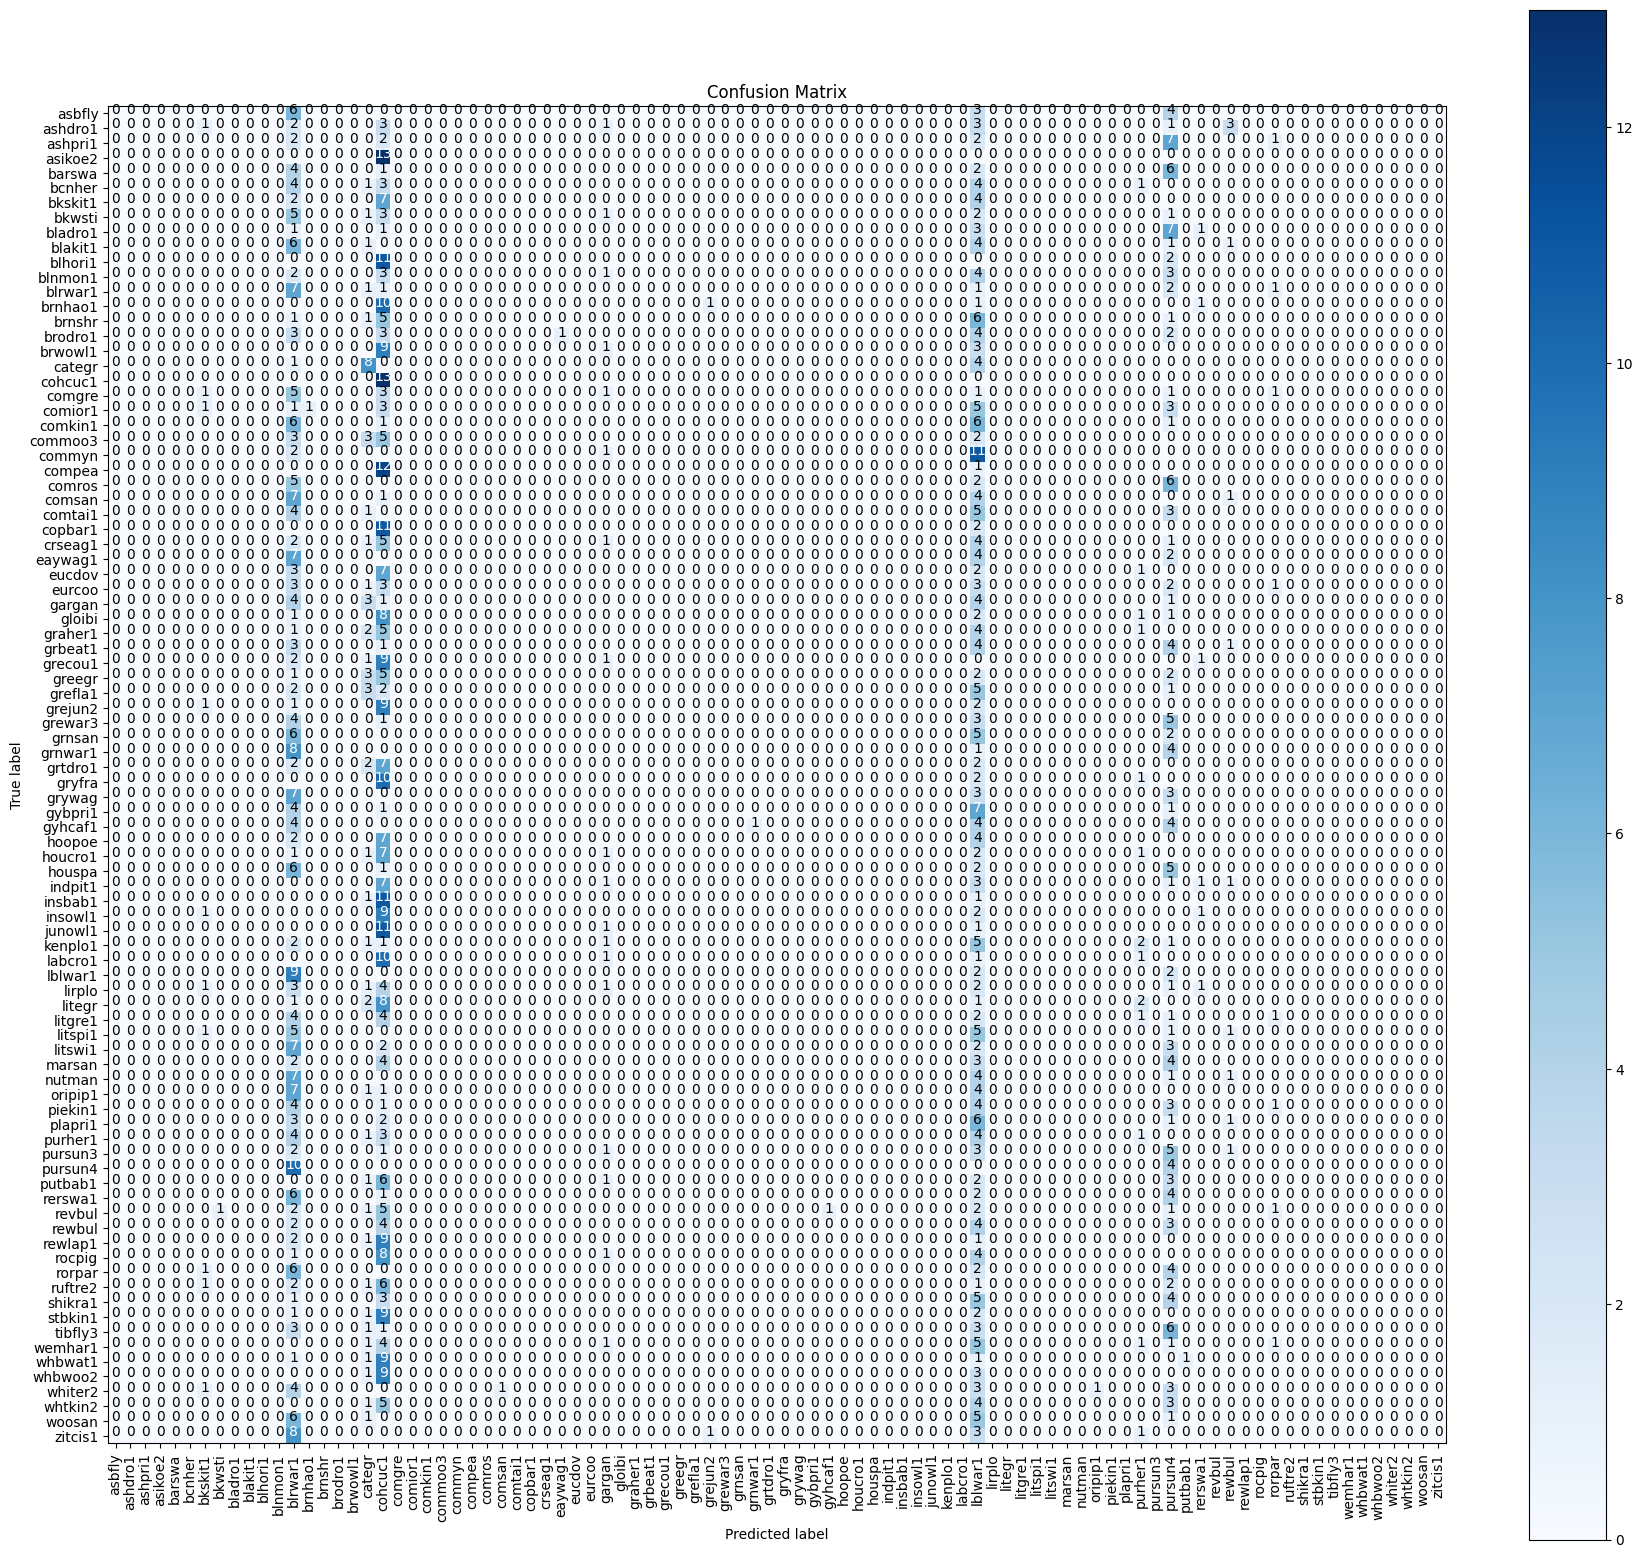


Classification report:

              precision    recall  f1-score   support

      asbfly     0.0000    0.0000    0.0000        13
     ashdro1     0.0000    0.0000    0.0000        14
     ashpri1     0.0000    0.0000    0.0000        14
     asikoe2     0.0000    0.0000    0.0000        13
      barswa     0.0000    0.0000    0.0000        13
      bcnher     0.0000    0.0000    0.0000        13
     bkskit1     0.0000    0.0000    0.0000        13
      bkwsti     0.0000    0.0000    0.0000        13
     bladro1     0.0000    0.0000    0.0000        13
     blakit1     0.0000    0.0000    0.0000        13
     blhori1     0.0000    0.0000    0.0000        13
     blnmon1     0.0000    0.0000    0.0000        13
     blrwar1     0.0261    0.5385    0.0498        13
     brnhao1     0.0000    0.0000    0.0000        13
      brnshr     0.0000    0.0000    0.0000        14
     brodro1     0.0000    0.0000    0.0000        13
     brwowl1     0.0000    0.0000    0.0000        13
  

/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [42]:
import matplotlib.pyplot as plt  # Correcting the import for pyplot

from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    f1_score,  # For F1 score
    confusion_matrix,  # For confusion matrix
    classification_report  # For classification report
)
import numpy as np
import itertools

# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))


In [24]:
# Saving the trained model to a file for future use.
trainer.save_model()